# Hearing related phenotypes

## Aim

Create a dataset of filtered individuals using the inclusion and exclusion criteria for diverse hearing related phenotyes to perform association analyses using the LMM.ipynb. 

## Location of files

In the shared folder is the original UKBB data
```
/SAY/dbgapstg/scratch/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020
```

In my personal folder the filtered dataset

```
/home/dc2325/project/HI_UKBB
```

## Important phenotypic files

1. `200804_UKBB_HI_genotypeqc.csv` File containing all individuals that passed QC and hearing impairment variables
2. `200804_UKBB_HI_genotypeqc_excr.csv` File with applied exclusion criteria as indicated [here](https://docs.google.com/document/d/1cpxTzElpsEkwmBDjnMBHg2wW7CL1AcG_b0_0wE_k5rQ/edit). **Note**: this file excludes individuals with otosclerosis, Meniere's and other diseases, if you need to filter those particular phenotypes use file 1 instead.
3. `200811_UKBB_Tinnitus_plan1_2_3_f4803` File with filtered phenotypes for tinnitus plan 1,2 and 3 and imputed noise variables
4. `200814_UKBB_HI_genotypeqc_excr_impvars` Database with qc'ed individuals, exclusion criteria, noise imputed vars and tinnitus phenotypes

## Subset the data using variables of interest

Using the ukbconvert software and a list of pre-specified variables

```
./ukbconv ukb42495.enc_ukb r -i/home/dc2325/project/HI_UKBB/selectvars_062520.txt -o/home/dc2325/project/HI_UKBB/ukb42495_subset062520
./ukbconv ukb42495.enc_ukb r -i/home/dc2325/project/HI_UKBB/selectvars_080420.txt -o/home/dc2325/project/HI_UKBB/ukb42495_subset080420
```

## Subsetting individuals with genotypic data

In [ ]:
#Load libraries
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)
library(rapportools)
library(ggplot2)
#Get working directory
getwd()
#Set working directory
setwd('~/project/HI_UKBB')

In [2]:
# Clean workspace
rm(list=ls())

In [ ]:
# Run script to import data to R
source("ukb42495_subset080420.r")
nrow(bd)

In [ ]:
# List of individuals with qc'ed genotypic files
df.geno <- read.table("/SAY/dbgapstg/scratch/UKBiobank/genotype_files/pleiotropy_geneticfiles/UKB_Caucasians_phenotypeindepqc120319_updated020720removedwithdrawnindiv.fam", header= FALSE, stringsAsFactors = FALSE)
names(df.geno) <-c("FID","IID","ignore1", "ignore2", "ignore3", "ignore4")
nrow(df.geno)

In [ ]:
head(bd[,1, drop=FALSE])

In [ ]:
# Assign individual ID column to bd f.eid
names(bd)[1] <- "IID"
head(bd[,1, drop=FALSE])

In [ ]:
# Merge the two data frames
df.gen.phen <-merge(df.geno, bd, by="IID", all=FALSE)
nrow(df.gen.phen)

In [ ]:
# Step 5 Save as csv file
write.csv(df.gen.phen,'200804_UKBB_HI_genotypeqc.csv', row.names = FALSE)

# Tinnitus phenotype (binary)

## Exclusion criteria based on ICD10, ICD9 codes and self-report
Apply the exclusion criteria defined by the group to remove unwanted individuals. This takes into account ICD10 codes, ICD9 codes and f.20002 (self-report). Please find a list of removed codes [here](https://docs.google.com/spreadsheets/d/12L7Cx4Ov8FppGVmG0DxL9uG-lVRHM5QJSea0nORyirQ/edit#gid=0). A total 12397 individuals were excluded in this step.

In [ ]:
# To get a list of removed individuals. Make sure the list with the strings each line has \bstring\b so it can be recognized by -w
cd /home/dc2325/project/HI_UKBB

In [ ]:
grep -w -f 200713_ICDcodes_exclusion.txt 200804_UKBB_HI_genotypeqc.csv > 200804_UKBB_excluded_individuals.csv
cat 200804_UKBB_excluded_individuals.csv | wc -l #12397 excluded

In [ ]:
# To get the clean db with the included individuals
grep -wv -f 200713_ICDcodes_exclusion.txt 200804_UKBB_HI_genotypeqc.csv > 200804_UKBB_HI_genotypeqc_excr.csv.csv
cat 200804_UKBB_HI_genotypeqc_excr.csv.csv | wc -l #354347 retained
# To obtain the duplicate lines (if they exist)
#comm -12 <(sort 200713_UKBB_genotypeqc_tinnitus_excr.csv) <(sort 200713_UKBB_excluded_individuals.csv)

## Import clean data

In [2]:
df_clean <- read.csv(file = '200804_UKBB_HI_genotypeqc_excr.csv', header=TRUE)

**Analysis plan:**

1. Individuals who currently have tinnitus (all three yes categories) vs no never only controlling for sex, age, noisy workplace and loud music frequency (“crude”) (No tinnitus vs anytype of tinnitus). For this analysis the missing data of the noise variables was imputed using the median for cases and controls separately

3. Individuals in the two top YES categories vs NO never (‘No’ tinnitus vs ‘Yes, now all of the time’ and ‘Yes, now most of the time’)

4. Individuals that say yes in the top 3 categories vs No never (Remove category ‘yes, but not now, but have it in the past’)

## Data summary and recode

In [4]:
dim(df_clean)

[1] 354347   1074

### Recode genetic sex f.22001

In [5]:
table(df_clean$f.22001)


Female   Male 
192414 161933 

In [8]:
df_clean$sex <- revalue(df_clean$f.22001.0.0, c("Male" = '0', 'Female'='1' ))
table(df_clean$sex)
dim(df_clean)


     1      0 
192414 161933 

## Filter out inconsistent cases
Recode 4 instances of field f.4803 with 0,1, and 9
* Yes, now most or all of the time : 1 
* Yes, now a lot of the time: 1 
* Yes, now some of the time: 1 
* Yes, but not now, but have in the past : 1 
* No, never: 0
* Do not know: 9 Prefer not to answer: NA

In [129]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No, never"= 0, 
                                            "Yes, but not now, but have in the past"= 1, 
                                            "Yes, now some of the time"= 1, 
                                            "Yes, now a lot of the time"= 1,
                                            "Yes, now most or all of the time"= 1,
                                            "Prefer not to answer"= NA,
                                            "Do not know"= 9 ))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.4803.0.0","f.4803.1.0","f.4803.2.0","f.4803.3.0")

# get a new data.frame with recoded columns added:
df_clean<-recode(df=df_clean,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df_clean,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df_clean[,i]));cat("\n")}

f.4803.0.0_recode summary:
    9     0     1 
 1989 80963 32642 

f.4803.1.0_recode summary:
    9     0     1 
  185 10561  4605 

f.4803.2.0_recode summary:
    9     0     1 
  410 23724 11589 

f.4803.3.0_recode summary:
   9    0    1 
  20 1664  726 



In [130]:
dim(df_clean)

[1] 354347   1079

### 1. Get patterns for all possible answers

In [131]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df_clean %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "001"  "0010" "0011" "009" 
[11] "01"   "010"  "0100" "011"  "0111" "019"  "09"   "090"  "091"  "099" 
[21] "1"    "10"   "100"  "1000" "101"  "1010" "1011" "11"   "110"  "1100"
[31] "1101" "111"  "1110" "1111" "119"  "19"   "190"  "191"  "1919" "199" 
[41] "9"    "90"   "900"  "901"  "9011" "909"  "91"   "911"  "99"   "990" 
[51] "991"  "999"

In [132]:
all_pattern<-unique(data_sub$visit)

cat("There are",length(all_pattern),"different combinations of answers.\n")

There are 52 different combinations of answers.


In [133]:
cat("Those with 4 numbers has answer for all 4 visits. e.g. '0000': No, No, No, No.\n")

Those with 4 numbers has answer for all 4 visits. e.g. '0000': No, No, No, No.


In [134]:
cat("Those with 3 numbers has answer for 3 answers out of 4 visits. e.g. '001': No, No, Yes. \n")

Those with 3 numbers has answer for 3 answers out of 4 visits. e.g. '001': No, No, Yes. 


In [135]:
cat("Those with 2 numbers has answer for 2 answers out of 4 visits. e.g. '90': Do not know, No. \n")

Those with 2 numbers has answer for 2 answers out of 4 visits. e.g. '90': Do not know, No. 


In [136]:
cat("The first one, i.e. '' is for NAs.\n")

The first one, i.e. '' is for NAs.


In [137]:
table(data_sub$visit)


            0     00    000   0000   0001    001   0010   0011    009     01 
207944  87438  10425   1475     73      4    122      3      3     10   1717 
   010   0100    011   0111    019     09    090    091    099      1     10 
    78      3    131      6      2     94     10      5      2  36961   1014 
   100   1000    101   1010   1011     11    110   1100   1101    111   1110 
    97      6     42      2      2   3717     59      3      5    430      4 
  1111    119     19    190    191   1919    199      9     90    900    901 
    19      4     76      4      8      1      1   2110     92     10      5 
  9011    909     91    911     99    990    991    999 
     1      3     85      9     28      1      2      1 

### 2. Extract consistent cases

In [138]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


    0    00   000  0000     1    11   111  1111     9    99   999 
87438 10425  1475    73 36961  3717   430    19  2110    28     1 

In [139]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


009  09 090 099  90 900 909 990 
 10  94  10   2  92  10   3   1 

In [140]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


 119   19  191 1919  199   91  911  991 
   4   76    8    1    1   85    9    2 

In [141]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100  011 0111   10  100 1000  101 1010 1011  110 
   4  122    3    3 1717   78    3  131    6 1014   97    6   42    2    2   59 
1100 1101 1110 
   3    5    4 

In [142]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


 019  091  190  901 9011 
   2    5    4    5    1 

In [143]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

### 3. Remove inconsistent cases and NAs

In [144]:
# get all the inconsistent cases:
exceptions<-c("91","911","991","0001","001","0011","01","011","0111", "091", "901", "9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 207944 NAs, removed

In [145]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 1636 inconsistent cases, removed

In [146]:
# removed those NAs and inconsistent cases: 
IID_cleaned<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  select(IID)

dim(IID_cleaned)

[1] 144767      1

In [147]:
IID_cleaned<-IID_cleaned[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_cleaned),"cases left")

After removing all the NAs and inconsistent cases, there are 144767 cases left

In [148]:
# get the dataset after cleansing: 
data_cleaned<-df_clean %>%
  filter(IID%in%IID_cleaned)

dim(data_cleaned)

[1] 144767   1079

# Filter tinnitus for different analyses

Recode 4 instances of field f.4803 with 4,3,2,1,0, and 9

* Yes, now most or all of the time : 4 
* Yes, now a lot of the time: 3 
* Yes, now some of the time: 2 
* Yes, but not now, but have in the past : 1 
* No, never: 0
* Do not know: 9 
* Prefer not to answer: NA

### 1. Recode f.4803

In [217]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No, never"= 0, 
                                            "Yes, but not now, but have in the past"= 1, 
                                            "Yes, now some of the time"= 2, 
                                            "Yes, now a lot of the time"= 3,
                                            "Yes, now most or all of the time"= 4,
                                            "Prefer not to answer"= NA,
                                            "Do not know"= 9 ))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.4803.0.0","f.4803.1.0","f.4803.2.0","f.4803.3.0")

# get a new data.frame with recoded columns added:
df_recode<-recode(df=data_cleaned,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=data_cleaned,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df_recode[,i]));cat("\n")}

f.4803.0.0_recode summary:
    9     0     1     3     4     2 
 1914 80809 11861  2862  7145  9817 

f.4803.1.0_recode summary:
    9     0     1     3     4     2 
  127 10286  1269   457  1207  1281 

f.4803.2.0_recode summary:
    9     0     1     3     4     2 
  236 22586  3373  1220  3127  3690 

f.4803.3.0_recode summary:
   9    0    1    3    4    2 
   1 1451  191   69  204  234 



### 2. Get patterns for all visits

In [218]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df_recode %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] "0"    "00"   "000"  "0000" "0001" "0002" "0004" "001"  "002"  "0022"
 [11] "003"  "0033" "004"  "01"   "011"  "0111" "012"  "0121" "013"  "014" 
 [21] "02"   "021"  "022"  "023"  "024"  "03"   "031"  "032"  "033"  "034" 
 [31] "0344" "04"   "041"  "042"  "0422" "043"  "044"  "092"  "093"  "1"   
 [41] "11"   "111"  "1111" "112"  "113"  "114"  "12"   "121"  "122"  "123" 
 [51] "124"  "13"   "132"  "133"  "134"  "14"   "142"  "143"  "144"  "2"   
 [61] "21"   "211"  "2111" "212"  "2122" "213"  "22"   "221"  "222"  "2222"
 [71] "223"  "224"  "23"   "231"  "2311" "232"  "2322" "233"  "234"  "24"  
 [81] "242"  "243"  "244"  "3"    "31"   "311"  "312"  "313"  "32"   "321" 
 [91] "322"  "323"  "324"  "33"   "3311" "332"  "333"  "3331" "3332" "334" 
[101] "34"   "341"  "342"  "343"  "344"  "4"    "41"   "42"   "421"  "422" 
[111] "423"  "424"  "4243" "43"   "432"  "433"  "434"  "44"   "441"  "442" 
[121] "443"  "444"  "4444" "9"    "901"  "902"  "9021" "903"  "904"  "91"  
[131] "911"  "912"  "92"   "921"  "923"  "924"  "93"   "932"  "933"  "934" 
[141] "94"   "942"  "99"   "991"  "999"

In [219]:
all_pattern<-unique(data_sub$visit)

cat("There are",length(all_pattern),"different combinations of answers.\n")

There are 145 different combinations of answers.


In [220]:
table(data_sub$visit)


    0    00   000  0000  0001  0002  0004   001   002  0022   003  0033   004 
87438 10425  1475    73     1     2     1    46    54     2     6     1    16 
   01   011  0111   012  0121   013   014    02   021   022   023   024    03 
  660    22     2    12     1     3     2   649    12    32     3     9   160 
  031   032   033   034  0344    04   041   042  0422   043   044   092   093 
    2     2     3     4     2   248     1     5     1     2    17     4     1 
    1    11   111  1111   112   113   114    12   121   122   123   124    13 
13564   607    50     2    10     3     1   277    14    18     4     3    55 
  132   133   134    14   142   143   144     2    21   211  2111   212  2122 
    1     2     1    80     3     2     7 11580   262    13     1    10     1 
  213    22   221   222  2222   223   224    23   231  2311   232  2322   233 
    2   557     7    29     1     7     1   158     4     1     6     1     7 
  234    24   242   243   244     3    31   311   3

# Analysis plan 1

## 1. Filter out the 9

In [221]:
# define cases and control for specific analysis:
all_answers<-c("0","1","2","3","4","9")
control<-c('0')
cases<-c("1","2","3","4")

f3<-function(x){
  get_rid_of<-setdiff(all_answers,union(cases,control))

  for (i in get_rid_of){
  if (grepl(i,x[which(colnames(data_sub)=="visit")])){
    removed=TRUE
    break
  }
  else{removed=FALSE}
  }
  return (removed)
}
data_p1<-data_sub
data_p1$removed<-apply(data_p1, 1, f3)

# filter 
data_p1<-data_p1 %>%
  filter(removed==FALSE)
head(data_p1,40)

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,visit,removed
,<int>,<fct>,<fct>,<fct>,<fct>,<chr>,<lgl>
1,1000046,NA,NA,0,NA,0,FALSE
2,1000063,0,NA,NA,NA,0,FALSE
3,1000078,NA,0,0,NA,00,FALSE
4,1000105,1,NA,NA,NA,1,FALSE
5,1000112,NA,NA,0,NA,0,FALSE
6,1000141,0,NA,NA,NA,0,FALSE
7,1000236,0,NA,0,NA,00,FALSE
8,1000248,0,NA,NA,NA,0,FALSE
9,1000269,NA,NA,0,NA,0,FALSE


In [222]:
# change all "1", "2" "3" and "4" into "1"
data_p1$visit<-gsub("1|2|3|4","1",data_p1$visit) 
table(data_p1$visit)


    0    00   000  0000  0001   001  0011    01   011  0111     1    11   111 
87438 10425  1475    73     4   122     3  1717   131     6 36961  3717   430 
 1111 
   19 

In [223]:
names(table(data_p1$visit))

[1] "0"    "00"   "000"  "0000" "0001" "001"  "0011" "01"   "011"  "0111"
[11] "1"    "11"   "111"  "1111"

In [224]:
# get the dataset for plan 1:
IID_plan1<-data_p1$IID
data_p1<-data_cleaned[which(data_cleaned$IID%in%IID_plan1),]
dim(data_p1)

[1] 142521   1079

In [225]:
head(data_p1[,column_name],40)

,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0
,<fct>,<fct>,<fct>,<fct>
1,NA,NA,"No, never",NA
2,"No, never",NA,NA,NA
3,NA,"No, never","No, never",NA
4,"Yes, but not now, but have in the past",NA,NA,NA
5,NA,NA,"No, never",NA
6,"No, never",NA,NA,NA
7,"No, never",NA,"No, never",NA
8,"No, never",NA,NA,NA
9,NA,NA,"No, never",NA


In [226]:
for (i in new_column_names)
{cat(i,"summary:");print(table(data_p1[,i]));cat("\n")}

f.4803.0.0_recode summary:
    9     0     1 
    0 80805 31685 

f.4803.1.0_recode summary:
    9     0     1 
    0 10282  4197 

f.4803.2.0_recode summary:
    9     0     1 
    0 22583 11324 

f.4803.3.0_recode summary:
   9    0    1 
   0 1451  684 



## 2. Define cases and controls: analysis plan 1

Define cases with tinnitus where all yes categories are considered cases

In [227]:
data_p1$cases <- with(data_p1, ifelse(f.4803.0.0_recode == '0' & (f.4803.1.0_recode == "1" | f.4803.2.0_recode == "1" | f.4803.3.0_recode == "1")   
                                      | (f.4803.0.0_recode %in% c("1",NA) & (f.4803.1.0_recode %in% c("1",NA) | f.4803.2.0_recode %in% c("1",NA) | f.4803.3.0_recode %in% c("1",NA)))
                                      & !(f.4803.0.0_recode %in% c("0",NA) & f.4803.1.0_recode %in% c("0",NA) & f.4803.2.0_recode %in% c("0",NA) & f.4803.3.0_recode %in% c("0",NA))
                                      ,"1", NA))

In [228]:
table(data_p1$cases) # Number of tinnitus cases


    1 
43110 

In [229]:
data_p1 %>%
select(IID,f.4803.0.0, f.4803.1.0, f.4803.2.0, f.4803.3.0, f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode,cases)
head(data_p1)

,IID,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,1000046,NA,NA,"No, never",NA,NA,NA,0,NA,NA
2,1000063,"No, never",NA,NA,NA,0,NA,NA,NA,NA
3,1000078,NA,"No, never","No, never",NA,NA,0,0,NA,NA
4,1000105,"Yes, but not now, but have in the past",NA,NA,NA,1,NA,NA,NA,1
5,1000112,NA,NA,"No, never",NA,NA,NA,0,NA,NA
6,1000141,"No, never",NA,NA,NA,0,NA,NA,NA,NA
7,1000236,"No, never",NA,"No, never",NA,0,NA,0,NA,NA
8,1000248,"No, never",NA,NA,NA,0,NA,NA,NA,NA
9,1000269,NA,NA,"No, never",NA,NA,NA,0,NA,NA


,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.43,f.41281.0.44,f.41281.0.45,f.41281.0.46,sex,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,NA,NA,1,NA,NA,0,NA,NA
2,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,NA,NA,0,0,NA,NA,NA,NA
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,NA,NA,1,NA,0,0,NA,NA
4,1000105,1000105,0,0,2,-9,Female,1955,2009-06-22,NA,⋯,NA,NA,NA,NA,1,1,NA,NA,NA,1
5,1000112,1000112,0,0,1,-9,Male,1949,2008-04-01,NA,⋯,NA,NA,NA,NA,0,NA,NA,0,NA,NA
6,1000141,1000141,0,0,2,-9,Female,1959,2009-10-26,NA,⋯,NA,NA,NA,NA,1,0,NA,NA,NA,NA


Define controls (no tinnitus)

In [230]:
data_p1$controls <- with(data_p1, ifelse(f.4803.0.0_recode %in% c("0",NA) & f.4803.1.0_recode %in% c("0", NA) & f.4803.2.0_recode %in% c("0",NA) &f.4803.3.0_recode %in% c("0",NA)
                                         & !(f.4803.0.0_recode %in% c(NA) & f.4803.1.0_recode %in% c(NA) & f.4803.2.0_recode %in% c(NA) & f.4803.3.0_recode %in% c(NA)) 
                                         ,"0", NA))

In [231]:
table(data_p1$controls) # Number of tinnitus controls


    0 
99411 

In [232]:
data_p1 %>%
select(IID,f.4803.0.0, f.4803.1.0, f.4803.2.0, f.4803.3.0, f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode,controls)
head(data_p1)

,IID,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,controls
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,1000046,NA,NA,"No, never",NA,NA,NA,0,NA,0
2,1000063,"No, never",NA,NA,NA,0,NA,NA,NA,0
3,1000078,NA,"No, never","No, never",NA,NA,0,0,NA,0
4,1000105,"Yes, but not now, but have in the past",NA,NA,NA,1,NA,NA,NA,NA
5,1000112,NA,NA,"No, never",NA,NA,NA,0,NA,0
6,1000141,"No, never",NA,NA,NA,0,NA,NA,NA,0
7,1000236,"No, never",NA,"No, never",NA,0,NA,0,NA,0
8,1000248,"No, never",NA,NA,NA,0,NA,NA,NA,0
9,1000269,NA,NA,"No, never",NA,NA,NA,0,NA,0


,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.44,f.41281.0.45,f.41281.0.46,sex,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases,controls
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>
1,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,NA,1,NA,NA,0,NA,NA,0
2,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,NA,0,0,NA,NA,NA,NA,0
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,NA,1,NA,0,0,NA,NA,0
4,1000105,1000105,0,0,2,-9,Female,1955,2009-06-22,NA,⋯,NA,NA,NA,1,1,NA,NA,NA,1,NA
5,1000112,1000112,0,0,1,-9,Male,1949,2008-04-01,NA,⋯,NA,NA,NA,0,NA,NA,0,NA,NA,0
6,1000141,1000141,0,0,2,-9,Female,1959,2009-10-26,NA,⋯,NA,NA,NA,1,0,NA,NA,NA,NA,0


Create a column with the binary status for tinnitus of the individuals

In [233]:
data_p1$tinnitus <- coalesce(data_p1$cases, data_p1$controls)
table(data_p1$tinnitus)


    0     1 
99411 43110 

In [234]:
# Get the number of NAs
length(which(is.na(data_p1$tinnitus)))

[1] 0

## 3. Obtaining the age for tinnitus cases and controls

Get the "age at onset" of tinnitus using f.21003 Age when attended assessment centre for each of the instances
For cases first time they replied yes to f.4803

In [235]:
# Get the subset of data to extract age
age_all = data_p1 %>% 
  filter(!is.na(tinnitus)) %>%
  select(IID,tinnitus, f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)  # data_filed 210003: Age when attended assessment centre
head(age_all)

,IID,tinnitus,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000046,0,NA,NA,0,NA,62,NA,73,NA
2,1000063,0,0,NA,NA,NA,43,NA,NA,NA
3,1000078,0,NA,0,0,NA,52,57,60,NA
4,1000105,1,1,NA,NA,NA,54,NA,NA,NA
5,1000112,0,NA,NA,0,NA,58,NA,68,NA
6,1000141,0,0,NA,NA,NA,49,NA,NA,NA


In [236]:
# Get the subset data of cases
age_cases = age_all %>% 
  filter(tinnitus=="1")  %>%
  select(IID,f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
head(age_cases,12)

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000105,1,NA,NA,NA,54,NA,NA,NA
2,1000357,1,NA,NA,NA,69,NA,NA,NA
3,1000443,NA,NA,1,NA,45,NA,52,NA
4,1000494,1,NA,NA,NA,61,NA,NA,NA
5,1000625,1,NA,NA,NA,60,NA,NA,NA
6,1000713,1,NA,1,NA,58,NA,67,NA
7,1000728,1,NA,NA,NA,61,NA,NA,NA
8,1000745,1,NA,NA,NA,60,NA,NA,NA
9,1000875,1,NA,NA,NA,59,NA,NA,NA


In [237]:
# Get the # of column where first replied Yes:
age_cases$visit_idx = apply(age_cases, 1, function(x) unlist(which(x == '1')))
head(age_cases)

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000105,1,NA,NA,NA,54,NA,NA,NA,2
2,1000357,1,NA,NA,NA,69,NA,NA,NA,2
3,1000443,NA,NA,1,NA,45,NA,52,NA,4
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2
5,1000625,1,NA,NA,NA,60,NA,NA,NA,2
6,1000713,1,NA,1,NA,58,NA,67,NA,"2, 4"


In [238]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.4803.0.0.rc)
offset = which(colnames(age_cases) == 'f.21003.0.0') - which(colnames(age_cases) == 'f.4803.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
age_cases$age_final = apply(age_cases, 1, f)

# Show first 6 rows
head(age_cases)
summary(age_cases$age_final)

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000105,1,NA,NA,NA,54,NA,NA,NA,2,54
2,1000357,1,NA,NA,NA,69,NA,NA,NA,2,69
3,1000443,NA,NA,1,NA,45,NA,52,NA,4,52
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61
5,1000625,1,NA,NA,NA,60,NA,NA,NA,2,60
6,1000713,1,NA,1,NA,58,NA,67,NA,"2, 4",58


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   40.0    54.0    61.0    59.6    66.0    81.0 

Get the age for controls last time they replied no to f.4803

In [239]:
# Get the subset data of controls
age_control = age_all %>% 
  filter(tinnitus=="0")  %>%
  select(IID,f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
head(age_control,12)

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000046,NA,NA,0,NA,62,NA,73,NA
2,1000063,0,NA,NA,NA,43,NA,NA,NA
3,1000078,NA,0,0,NA,52,57,60,NA
4,1000112,NA,NA,0,NA,58,NA,68,NA
5,1000141,0,NA,NA,NA,49,NA,NA,NA
6,1000236,0,NA,0,NA,61,NA,70,NA
7,1000248,0,NA,NA,NA,63,NA,NA,NA
8,1000269,NA,NA,0,NA,60,NA,71,NA
9,1000340,0,NA,NA,NA,54,NA,NA,NA


In [240]:
# Get the # of column where last replied No:
age_control$visit_idx = apply(age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.4803.0.0.rc)
offset = which(colnames(age_control) == 'f.21003.0.0') - which(colnames(age_control) == 'f.4803.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
age_control$age_final = apply(age_control, 1, f)

# Show first 6 rows
head(age_control)
summary(age_control$age_final)

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000046,NA,NA,0,NA,62,NA,73,NA,4,73
2,1000063,0,NA,NA,NA,43,NA,NA,NA,2,43
3,1000078,NA,0,0,NA,52,57,60,NA,"3, 4",60
4,1000112,NA,NA,0,NA,58,NA,68,NA,4,68
5,1000141,0,NA,NA,NA,49,NA,NA,NA,2,49
6,1000236,0,NA,0,NA,61,NA,70,NA,"2, 4",70


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   53.00   60.00   59.09   65.00   82.00 

In [241]:
# Merge age_cases and age_controls
age_tinnitus <- rbind(age_cases, age_control) 
dim(age_tinnitus)
head(age_tinnitus)

[1] 142521     11

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000105,1,NA,NA,NA,54,NA,NA,NA,2,54
2,1000357,1,NA,NA,NA,69,NA,NA,NA,2,69
3,1000443,NA,NA,1,NA,45,NA,52,NA,4,52
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61
5,1000625,1,NA,NA,NA,60,NA,NA,NA,2,60
6,1000713,1,NA,1,NA,58,NA,67,NA,"2, 4",58


In [242]:
#Merge with complete database keep the all the rows from original db
df.age = merge(x = data_p1,y = age_tinnitus[,c("IID","age_final")],by="IID", all.x=TRUE)
dim(df.age)

[1] 142521   1083

## 4. Recode noisy workplace f.4825 and loud music frequency exposure f.4836

In [186]:
# Recode function:
recode_ordinal<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= "0", 
                                            "Yes, for less than a year"= "1", 
                                            "Yes, for around 1-5 years"= "2", 
                                            "Yes, for more than 5 years"= "3",
                                            "Prefer not to answer"= NA,
                                            "Do not know"= NA ))
    df[,new_column_name] <- ordered(df[,new_column_name] , c("0", "1", "2", "3"))
  }
  return (list(df=df,new_column_names=new_names))
}
# columns needs to be recoded:
column_name<-c("f.4825.0.0", "f.4825.1.0", "f.4825.2.0", "f.4825.3.0","f.4836.0.0", "f.4836.1.0", "f.4836.2.0", "f.4836.3.0")
# get a new data.frame with recoded columns added:
data_cleaned<-recode_ordinal(df=data_cleaned,column_name)$df
# get names of recoded columns:
new_column_names<-recode_ordinal(df=data_cleaned,column_name)$new_column_names
# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(data_cleaned[,i]));cat("\n")}

f.4825.0.0_recode summary:
    0     1     2     3 
85405  6018  6398 13823 

f.4825.1.0_recode summary:
    0     1     2     3 
11468   750   731  1443 

f.4825.2.0_recode summary:
    0     1     2     3 
27162  1632  1648  3268 

f.4825.3.0_recode summary:
   0    1    2    3 
1723  115   96  189 

f.4836.0.0_recode summary:
    0     1     2     3 
97918  3316  5172  4706 

f.4836.1.0_recode summary:
    0     1     2     3 
12916   343   552   498 

f.4836.2.0_recode summary:
    0     1     2     3 
29963   862  1360  1316 

f.4836.3.0_recode summary:
   0    1    2    3 
1873   58  100   76 



## 5. Checking consistency of the f.4825 noisy workplace and filtering

In [187]:
# Extract subset of data only with the recode columns of noisy workplace variable
data_noise <- df.age %>%
  select(IID, "f.4825.0.0_recode", "f.4825.1.0_recode", "f.4825.2.0_recode", "f.4825.3.0_recode")  
dim(data_noise)

[1] 142521      5

In [188]:
# Function to extract all the available answers for 4 visits
# and put them in one list
f<-function(x){
  visit<-c()
  for (i in 2:5){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=as.numeric(visit)}
  return (visit)
}

# Apply the above function and remove NAs
data_noise$visit<-apply(data_noise, 1, f)

In [189]:
data_noise<-data_noise %>%
  filter(!is.na(visit)) 
head(data_noise)
dim(data_noise)

,IID,f.4825.0.0_recode,f.4825.1.0_recode,f.4825.2.0_recode,f.4825.3.0_recode,visit
,<int>,<ord>,<ord>,<ord>,<ord>,<list>
1,1000046,NA,NA,0,NA,0
2,1000063,0,NA,NA,NA,0
3,1000078,NA,0,0,NA,"0, 0"
4,1000105,0,NA,NA,NA,0
5,1000112,NA,NA,0,NA,0
6,1000141,0,NA,NA,NA,0


[1] 141560      6

In [190]:
# Function to get the final code for noise_wp
f<-function(x){
  l=length(x$visit)
  if (l==1){ # only one answer available
    result=x$visit
  }
  else{ # more then one answer available
    result=x$visit[1]
    for (i in 2:l){
      if (x$visit[i] >= x$visit[i-1]){result=x$visit[i]} # consistent ones
      else {result=NA; break} # inconsistent ones
    }
  }
  return(result)
}

# Apply the above function and remove NAs
data_noise$noise_wp<-apply(data_noise, 1, f)
data_noise<-data_noise %>%
  filter(!is.na(noise_wp)) 
head(data_noise, 12) # note: noise_wp code generated here is numeric, not factor
dim(data_noise)

,IID,f.4825.0.0_recode,f.4825.1.0_recode,f.4825.2.0_recode,f.4825.3.0_recode,visit,noise_wp
,<int>,<ord>,<ord>,<ord>,<ord>,<list>,<dbl>
1,1000046,NA,NA,0,NA,0,0
2,1000063,0,NA,NA,NA,0,0
3,1000078,NA,0,0,NA,"0, 0",0
4,1000105,0,NA,NA,NA,0,0
5,1000112,NA,NA,0,NA,0,0
6,1000141,0,NA,NA,NA,0,0
7,1000236,0,NA,0,NA,"0, 0",0
8,1000248,3,NA,NA,NA,3,3
9,1000269,NA,NA,0,NA,0,0


[1] 140338      7

In [192]:
# Append the noise variable to the data
df.noise = merge(x = df.age,y = data_noise[,c("IID", "noise_wp")],by="IID", all.x=TRUE)
dim(df.noise)

[1] 142521   1092

## 6. Checking consistency of the f.4836 loud music exposure frequency and filtering

In [193]:
# Extract subset of data only with the recode columns of loud music exposure variable f.4836
data_music <-  df.age %>%
  select(IID,f.4836.0.0_recode,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode) 
head(data_music)
dim(data_music)

,IID,f.4836.0.0_recode,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode
,<int>,<ord>,<ord>,<ord>,<ord>
1,1000046,NA,NA,0,NA
2,1000063,0,NA,NA,NA
3,1000078,NA,0,0,NA
4,1000105,0,NA,NA,NA
5,1000112,NA,NA,0,NA
6,1000141,0,NA,NA,NA


[1] 142521      5

In [194]:
# Function to extract all the available answers for 4 visits
# and put them in one list

f<-function(x){
  visit<-c()
  for (i in 2:5){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=as.numeric(visit)}
  return (visit)
}

# Apply the above function and remove NAs
                              
data_music$visit<-apply(data_music, 1, f)
data_music<-data_music %>%
  filter(!is.na(visit)) 
head(data_music)
dim(data_music)

,IID,f.4836.0.0_recode,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,visit
,<int>,<ord>,<ord>,<ord>,<ord>,<list>
1,1000046,NA,NA,0,NA,0
2,1000063,0,NA,NA,NA,0
3,1000078,NA,0,0,NA,"0, 0"
4,1000105,0,NA,NA,NA,0
5,1000112,NA,NA,0,NA,0
6,1000141,0,NA,NA,NA,0


[1] 140946      6

In [195]:
# Function to get the final code for "loud_music"
f<-function(x){
  l=length(x$visit)
  if (l==1){ # only one answer available
    result=x$visit
  }
  else{ # more then one answer available
    result=x$visit[1]
    for (i in 2:l){
      if (x$visit[i] >= x$visit[i-1]){result=x$visit[i]} # consistent ones
      else {result=NA; break} # inconsistent ones
    }
  }
  return(result)
}

# Apply the above function and remove NAs
data_music$loud_music<-apply(data_music, 1, f)
data_music<-data_music %>%
  filter(!is.na(loud_music)) 
head(data_music, 12) # note: loud_music code generated here is numeric, not factor
dim(data_music)

,IID,f.4836.0.0_recode,f.4836.1.0_recode,f.4836.2.0_recode,f.4836.3.0_recode,visit,loud_music
,<int>,<ord>,<ord>,<ord>,<ord>,<list>,<dbl>
1,1000046,NA,NA,0,NA,0,0
2,1000063,0,NA,NA,NA,0,0
3,1000078,NA,0,0,NA,"0, 0",0
4,1000105,0,NA,NA,NA,0,0
5,1000112,NA,NA,0,NA,0,0
6,1000141,0,NA,NA,NA,0,0
7,1000236,0,NA,0,NA,"0, 0",0
8,1000248,0,NA,NA,NA,0,0
9,1000269,NA,NA,0,NA,0,0


[1] 139724      7

In [196]:
# Merge all of the variables in the final dataset
df.final = merge(x = df.noise,y = data_music[,c("IID", "loud_music")],by="IID", all.x=TRUE)
dim(df.final)  

[1] 142521   1093

## Export file: tinnitus complete cases

In [197]:
# Last renaming and recoding
names(df.final)[names(df.final) == "age_final"] <- "age"

# Creating the file for subsequent association analyses

tinnitus_cc <- df.final %>%
  filter(!is.na(tinnitus)) %>%
  select(FID, IID, age, sex, tinnitus, noise_wp, loud_music)
head(tinnitus_cc)
dim(tinnitus_cc)

,FID,IID,age,sex,tinnitus,noise_wp,loud_music
,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<dbl>
1,1000046,1000046,73,1,0,0,0
2,1000063,1000063,43,0,0,0,0
3,1000078,1000078,60,1,0,0,0
4,1000105,1000105,54,1,1,0,0
5,1000112,1000112,68,0,0,0,0
6,1000141,1000141,49,1,0,0,0


[1] 142521      7

In [198]:
length(which(is.na(tinnitus_cc$noise_wp))) #missing data for noisy workplace

[1] 2183

In [199]:
length(which(is.na(tinnitus_cc$loud_music))) #missing data for loud_music

[1] 2797

In [200]:
length(which(is.na(tinnitus_cc$loud_music) & is.na(tinnitus_cc$noise_wp))) #missing data for both covariates

[1] 304

In [201]:
length(which(is.na(tinnitus_cc$loud_music) | is.na(tinnitus_cc$noise_wp))) #noise variables missing cases

[1] 4676

## Imputation of noise variables using the median

Calculate mean and median for the entire sample (n=142,082)

In [202]:
mean(tinnitus_cc$noise_wp, na.rm=TRUE)
median(tinnitus_cc$noise_wp, na.rm=TRUE)

[1] 0.5213271

[1] 0

Calculate the mean and median in cases and controls

In [203]:
mean(subset(tinnitus_cc, tinnitus == 1)$noise_wp, na.rm=TRUE)
median(subset(tinnitus_cc, tinnitus == 1)$noise_wp, na.rm=TRUE)

[1] 0.7694675

[1] 0

In [204]:
mean(subset(tinnitus_cc, tinnitus == 0)$noise_wp, na.rm=TRUE)
median(subset(tinnitus_cc, tinnitus == 0)$noise_wp, na.rm=TRUE)

[1] 0.4144912

[1] 0

Impute values of noisy workplace and loud music exposure using the median

In [205]:
df.noise <-df.final %>% 
  filter(!is.na(tinnitus)) %>%
  select(IID, tinnitus, noise_wp, loud_music) %>%
  group_by(tinnitus) %>%
  mutate(noise_wp=ifelse(is.na(noise_wp),median(noise_wp,na.rm=TRUE),noise_wp)) %>%
  mutate(loud_music=ifelse(is.na(loud_music),median(loud_music,na.rm=TRUE),loud_music))

In [206]:
head(df.noise, 10)

IID,tinnitus,noise_wp,loud_music
<int>,<chr>,<dbl>,<dbl>
1000046,0,0,0
1000063,0,0,0
1000078,0,0,0
1000105,1,0,0
1000112,0,0,0
1000141,0,0,0
1000236,0,0,0
1000248,0,3,0
1000269,0,0,0


In [207]:
names(df.noise)[names(df.noise)=="noise_wp"] <- "noise_imp"
names(df.noise)[names(df.noise)=="loud_music"] <- "music_imp"
head(df.noise)

IID,tinnitus,noise_imp,music_imp
<int>,<chr>,<dbl>,<dbl>
1000046,0,0,0
1000063,0,0,0
1000078,0,0,0
1000105,1,0,0
1000112,0,0,0
1000141,0,0,0


Merge with complete database including cases and controls for tinnitus plan 1

In [208]:
tinnitus_cc_imp <- merge(x = tinnitus_cc,y = df.noise[,c("IID","noise_imp","music_imp")],by="IID", all.x=TRUE)
dim(tinnitus_cc_imp)
tinnitus_plan1 <- tinnitus_cc_imp %>%
    select(FID, IID, age, sex, tinnitus, noise_wp, loud_music, noise_imp, music_imp)
head(tinnitus_plan1)

[1] 142521      9

,FID,IID,age,sex,tinnitus,noise_wp,loud_music,noise_imp,music_imp
,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,73,1,0,0,0,0,0
2,1000063,1000063,43,0,0,0,0,0,0
3,1000078,1000078,60,1,0,0,0,0,0
4,1000105,1000105,54,1,1,0,0,0,0
5,1000112,1000112,68,0,0,0,0,0,0
6,1000141,1000141,49,1,0,0,0,0,0


# Analysis plan 2

## 1. Filter out 9, 1 and 2

In [243]:
# define cases and control for specific analysis:
all_answers<-c("0","1","2","3","4","9")
control<-c("0")
cases<-c("3","4")

f3 <- function(x){
  get_rid_of<-setdiff(all_answers,union(cases,control))
  for (i in get_rid_of){
  if (grepl(i,x[which(colnames(data_sub)=="visit")])){
    removed=TRUE
    break
  }
  else{removed=FALSE}
  }
  return (removed)
}
data_p2<-data_sub
data_p2$removed<-apply(data_p2, 1, f3)

# filter 
data_p2<-data_p2 %>%
  filter(removed==FALSE)
head(data_p2,40)
dim(data_p2)

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,visit,removed
,<int>,<fct>,<fct>,<fct>,<fct>,<chr>,<lgl>
1,1000046,NA,NA,0,NA,0,FALSE
2,1000063,0,NA,NA,NA,0,FALSE
3,1000078,NA,0,0,NA,00,FALSE
4,1000112,NA,NA,0,NA,0,FALSE
5,1000141,0,NA,NA,NA,0,FALSE
6,1000236,0,NA,0,NA,00,FALSE
7,1000248,0,NA,NA,NA,0,FALSE
8,1000269,NA,NA,0,NA,0,FALSE
9,1000340,0,NA,NA,NA,0,FALSE


[1] 113063      7

In [244]:
# change all "3" and "4" into "1"
data_p2$visit<-gsub("3|4","1",data_p2$visit) 
table(data_p2$visit)


    0    00   000  0000  0001   001  0011    01   011  0111     1    11   111 
87438 10425  1475    73     1    22     1   408    26     2 11817  1221   146 
 1111 
    8 

In [245]:
names(table(data_p2$visit))

[1] "0"    "00"   "000"  "0000" "0001" "001"  "0011" "01"   "011"  "0111"
[11] "1"    "11"   "111"  "1111"

In [246]:
# get the dataset for plan 2:
IID_plan2<-data_p2$IID
data_p2<-data_cleaned[which(data_cleaned$IID%in%IID_plan2),]
dim(data_p2)

[1] 113063   1079

In [247]:
head(data_p2[,column_name],40)

,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0
,<fct>,<fct>,<fct>,<fct>
1,NA,NA,"No, never",NA
2,"No, never",NA,NA,NA
3,NA,"No, never","No, never",NA
5,NA,NA,"No, never",NA
6,"No, never",NA,NA,NA
7,"No, never",NA,"No, never",NA
8,"No, never",NA,NA,NA
9,NA,NA,"No, never",NA
10,"No, never",NA,NA,NA


## 2. Define cases and controls: analysis plan 2

In [258]:
data_p2$cases <- with(data_p2, ifelse(f.4803.0.0_recode == '0' & (f.4803.1.0_recode == "1" | f.4803.2.0_recode == "1" | f.4803.3.0_recode == "1")   
                                      | (f.4803.0.0_recode %in% c("1",NA) & (f.4803.1.0_recode %in% c("1",NA) | f.4803.2.0_recode %in% c("1",NA) | f.4803.3.0_recode %in% c("1",NA)))
                                      & !(f.4803.0.0_recode %in% c("0",NA) & f.4803.1.0_recode %in% c("0",NA) & f.4803.2.0_recode %in% c("0",NA) & f.4803.3.0_recode %in% c("0",NA))
                                      ,"1", NA))

In [259]:
table(data_p2$cases) # Number of tinnitus cases


    1 
13652 

In [260]:
data_p2 %>%
select(IID,f.4803.0.0, f.4803.1.0, f.4803.2.0, f.4803.3.0, f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode,cases)
head(data_p2)

,IID,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,1000046,NA,NA,"No, never",NA,NA,NA,0,NA,NA
2,1000063,"No, never",NA,NA,NA,0,NA,NA,NA,NA
3,1000078,NA,"No, never","No, never",NA,NA,0,0,NA,NA
5,1000112,NA,NA,"No, never",NA,NA,NA,0,NA,NA
6,1000141,"No, never",NA,NA,NA,0,NA,NA,NA,NA
7,1000236,"No, never",NA,"No, never",NA,0,NA,0,NA,NA
8,1000248,"No, never",NA,NA,NA,0,NA,NA,NA,NA
9,1000269,NA,NA,"No, never",NA,NA,NA,0,NA,NA
10,1000340,"No, never",NA,NA,NA,0,NA,NA,NA,NA


,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.43,f.41281.0.44,f.41281.0.45,f.41281.0.46,sex,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,NA,NA,1,NA,NA,0,NA,NA
2,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,NA,NA,0,0,NA,NA,NA,NA
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,NA,NA,1,NA,0,0,NA,NA
5,1000112,1000112,0,0,1,-9,Male,1949,2008-04-01,NA,⋯,NA,NA,NA,NA,0,NA,NA,0,NA,NA
6,1000141,1000141,0,0,2,-9,Female,1959,2009-10-26,NA,⋯,NA,NA,NA,NA,1,0,NA,NA,NA,NA
7,1000236,1000236,0,0,1,-9,Male,1948,2010-01-30,NA,⋯,NA,NA,NA,NA,0,0,NA,0,NA,NA


In [261]:
data_p2$controls <- with(data_p2, ifelse(f.4803.0.0_recode %in% c("0",NA) & f.4803.1.0_recode %in% c("0", NA) & f.4803.2.0_recode %in% c("0",NA) &f.4803.3.0_recode %in% c("0",NA)
                                         & !(f.4803.0.0_recode %in% c(NA) & f.4803.1.0_recode %in% c(NA) & f.4803.2.0_recode %in% c(NA) & f.4803.3.0_recode %in% c(NA)) 
                                         ,"0", NA))

In [262]:
table(data_p2$controls) # Number of tinnitus controls


    0 
99411 

In [263]:
data_p2 %>%
select(IID,f.4803.0.0, f.4803.1.0, f.4803.2.0, f.4803.3.0, f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode,controls)
head(data_p2)

,IID,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,controls
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,1000046,NA,NA,"No, never",NA,NA,NA,0,NA,0
2,1000063,"No, never",NA,NA,NA,0,NA,NA,NA,0
3,1000078,NA,"No, never","No, never",NA,NA,0,0,NA,0
5,1000112,NA,NA,"No, never",NA,NA,NA,0,NA,0
6,1000141,"No, never",NA,NA,NA,0,NA,NA,NA,0
7,1000236,"No, never",NA,"No, never",NA,0,NA,0,NA,0
8,1000248,"No, never",NA,NA,NA,0,NA,NA,NA,0
9,1000269,NA,NA,"No, never",NA,NA,NA,0,NA,0
10,1000340,"No, never",NA,NA,NA,0,NA,NA,NA,0


,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.44,f.41281.0.45,f.41281.0.46,sex,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases,controls
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>
1,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,NA,1,NA,NA,0,NA,NA,0
2,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,NA,0,0,NA,NA,NA,NA,0
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,NA,1,NA,0,0,NA,NA,0
5,1000112,1000112,0,0,1,-9,Male,1949,2008-04-01,NA,⋯,NA,NA,NA,0,NA,NA,0,NA,NA,0
6,1000141,1000141,0,0,2,-9,Female,1959,2009-10-26,NA,⋯,NA,NA,NA,1,0,NA,NA,NA,NA,0
7,1000236,1000236,0,0,1,-9,Male,1948,2010-01-30,NA,⋯,NA,NA,NA,0,0,NA,0,NA,NA,0


Create a column with the binary status

In [264]:
data_p2$tinnitus_p2 <- coalesce(data_p2$cases, data_p2$controls)
table(data_p2$tinnitus_p2)


    0     1 
99411 13652 

In [ ]:
# Get the number of NAs
length(which(is.na(data_p2$tinnitus)))

In [267]:
tinnitus_cc_p2 <- merge(x = tinnitus_cc_imp,y = data_p2[,c("IID","tinnitus_p2")],by="IID", all.x=TRUE)
dim(tinnitus_cc_p2)
tinnitus_plan2 <- tinnitus_cc_p2 %>%
    select(FID, IID, age, sex, tinnitus, tinnitus_p2,noise_wp, loud_music, noise_imp, music_imp)
head(tinnitus_plan2)

[1] 142521     10

,FID,IID,age,sex,tinnitus,tinnitus_p2,noise_wp,loud_music,noise_imp,music_imp
,<int>,<int>,<int>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,73,1,0,0,0,0,0,0
2,1000063,1000063,43,0,0,0,0,0,0,0
3,1000078,1000078,60,1,0,0,0,0,0,0
4,1000105,1000105,54,1,1,NA,0,0,0,0
5,1000112,1000112,68,0,0,0,0,0,0,0
6,1000141,1000141,49,1,0,0,0,0,0,0


# Analysis plan 3

## 1. Filter out the 9 and 1

In [249]:
# define cases and control for specific analysis:
all_answers<-c("0","1","2","3","4","9")
control<-c('0')
cases<-c("2","3","4")

data_p3<-data_sub
data_p3$removed<-apply(data_p3, 1, f3)

# filter 
data_p3<-data_p3 %>%
  filter(removed==FALSE)
head(data_p3,40)

,IID,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,visit,removed
,<int>,<fct>,<fct>,<fct>,<fct>,<chr>,<lgl>
1,1000046,NA,NA,0,NA,0,FALSE
2,1000063,0,NA,NA,NA,0,FALSE
3,1000078,NA,0,0,NA,00,FALSE
4,1000112,NA,NA,0,NA,0,FALSE
5,1000141,0,NA,NA,NA,0,FALSE
6,1000236,0,NA,0,NA,00,FALSE
7,1000248,0,NA,NA,NA,0,FALSE
8,1000269,NA,NA,0,NA,0,FALSE
9,1000340,0,NA,NA,NA,0,FALSE


In [251]:
# change all "2" and "3" into "4"
data_p3$visit<-gsub("2|3|4","1",data_p3$visit) 
table(data_p3$visit)


    0    00   000  0000  0001   001  0011    01   011  0111     1    11   111 
87438 10425  1475    73     3    76     3  1057    77     3 23397  2351   264 
 1111 
   12 

In [253]:
names(table(data_p3$visit))

[1] "0"    "00"   "000"  "0000" "0001" "001"  "0011" "01"   "011"  "0111"
[11] "1"    "11"   "111"  "1111"

In [255]:
IID_plan3<-data_p3$IID
data_p3<-data_cleaned[which(data_cleaned$IID%in%IID_plan3),]
dim(data_p3)

[1] 126654   1079

In [257]:
head(data_p3[,column_name],40)

,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0
,<fct>,<fct>,<fct>,<fct>
1,NA,NA,"No, never",NA
2,"No, never",NA,NA,NA
3,NA,"No, never","No, never",NA
5,NA,NA,"No, never",NA
6,"No, never",NA,NA,NA
7,"No, never",NA,"No, never",NA
8,"No, never",NA,NA,NA
9,NA,NA,"No, never",NA
10,"No, never",NA,NA,NA


## 2. Define cases and controls: analysis plan 3

In [268]:
data_p3$cases <- with(data_p3, ifelse(f.4803.0.0_recode == '0' & (f.4803.1.0_recode == "1" | f.4803.2.0_recode == "1" | f.4803.3.0_recode == "1")   
                                      | (f.4803.0.0_recode %in% c("1",NA) & (f.4803.1.0_recode %in% c("1",NA) | f.4803.2.0_recode %in% c("1",NA) | f.4803.3.0_recode %in% c("1",NA)))
                                      & !(f.4803.0.0_recode %in% c("0",NA) & f.4803.1.0_recode %in% c("0",NA) & f.4803.2.0_recode %in% c("0",NA) & f.4803.3.0_recode %in% c("0",NA))
                                      ,"1", NA))

In [269]:
table(data_p3$cases) # Number of tinnitus cases


    1 
27243 

In [271]:
data_p3 %>%
select(IID,f.4803.0.0, f.4803.1.0, f.4803.2.0, f.4803.3.0, f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode,cases)
head(data_p2)

,IID,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,1000046,NA,NA,"No, never",NA,NA,NA,0,NA,NA
2,1000063,"No, never",NA,NA,NA,0,NA,NA,NA,NA
3,1000078,NA,"No, never","No, never",NA,NA,0,0,NA,NA
5,1000112,NA,NA,"No, never",NA,NA,NA,0,NA,NA
6,1000141,"No, never",NA,NA,NA,0,NA,NA,NA,NA
7,1000236,"No, never",NA,"No, never",NA,0,NA,0,NA,NA
8,1000248,"No, never",NA,NA,NA,0,NA,NA,NA,NA
9,1000269,NA,NA,"No, never",NA,NA,NA,0,NA,NA
10,1000340,"No, never",NA,NA,NA,0,NA,NA,NA,NA


,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.45,f.41281.0.46,sex,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases,controls,tinnitus_p2
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>
1,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,1,NA,NA,0,NA,NA,0,0
2,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,0,0,NA,NA,NA,NA,0,0
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,1,NA,0,0,NA,NA,0,0
5,1000112,1000112,0,0,1,-9,Male,1949,2008-04-01,NA,⋯,NA,NA,0,NA,NA,0,NA,NA,0,0
6,1000141,1000141,0,0,2,-9,Female,1959,2009-10-26,NA,⋯,NA,NA,1,0,NA,NA,NA,NA,0,0
7,1000236,1000236,0,0,1,-9,Male,1948,2010-01-30,NA,⋯,NA,NA,0,0,NA,0,NA,NA,0,0


In [272]:
data_p3$controls <- with(data_p3, ifelse(f.4803.0.0_recode %in% c("0",NA) & f.4803.1.0_recode %in% c("0", NA) & f.4803.2.0_recode %in% c("0",NA) &f.4803.3.0_recode %in% c("0",NA)
                                         & !(f.4803.0.0_recode %in% c(NA) & f.4803.1.0_recode %in% c(NA) & f.4803.2.0_recode %in% c(NA) & f.4803.3.0_recode %in% c(NA)) 
                                         ,"0", NA))

In [273]:
table(data_p3$controls)  # Number of tinnitus controls


    0 
99411 

In [275]:
data_p3 %>%
select(IID,f.4803.0.0, f.4803.1.0, f.4803.2.0, f.4803.3.0, f.4803.0.0_recode, f.4803.1.0_recode, f.4803.2.0_recode, f.4803.3.0_recode,controls)
head(data_p3)

,IID,f.4803.0.0,f.4803.1.0,f.4803.2.0,f.4803.3.0,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,controls
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
1,1000046,NA,NA,"No, never",NA,NA,NA,0,NA,0
2,1000063,"No, never",NA,NA,NA,0,NA,NA,NA,0
3,1000078,NA,"No, never","No, never",NA,NA,0,0,NA,0
5,1000112,NA,NA,"No, never",NA,NA,NA,0,NA,0
6,1000141,"No, never",NA,NA,NA,0,NA,NA,NA,0
7,1000236,"No, never",NA,"No, never",NA,0,NA,0,NA,0
8,1000248,"No, never",NA,NA,NA,0,NA,NA,NA,0
9,1000269,NA,NA,"No, never",NA,NA,NA,0,NA,0
10,1000340,"No, never",NA,NA,NA,0,NA,NA,NA,0


,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.44,f.41281.0.45,f.41281.0.46,sex,f.4803.0.0_recode,f.4803.1.0_recode,f.4803.2.0_recode,f.4803.3.0_recode,cases,controls
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>
1,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,NA,1,NA,NA,0,NA,NA,0
2,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,NA,0,0,NA,NA,NA,NA,0
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,NA,1,NA,0,0,NA,NA,0
5,1000112,1000112,0,0,1,-9,Male,1949,2008-04-01,NA,⋯,NA,NA,NA,0,NA,NA,0,NA,NA,0
6,1000141,1000141,0,0,2,-9,Female,1959,2009-10-26,NA,⋯,NA,NA,NA,1,0,NA,NA,NA,NA,0
7,1000236,1000236,0,0,1,-9,Male,1948,2010-01-30,NA,⋯,NA,NA,NA,0,0,NA,0,NA,NA,0


In [276]:
data_p3$tinnitus_p3 <- coalesce(data_p3$cases, data_p3$controls)
table(data_p3$tinnitus_p3)


    0     1 
99411 27243 

In [277]:
# Get the number of NAs
length(which(is.na(data_p3$tinnitus_p3)))

[1] 0

In [279]:
tinnitus_cc_p3 <- merge(x = tinnitus_cc_p2,y = data_p3[,c("IID","tinnitus_p3")],by="IID", all.x=TRUE)
dim(tinnitus_cc_p3)
tinnitus_plan3 <- tinnitus_cc_p3 %>%
    select(FID, IID, age, sex, tinnitus, tinnitus_p2, tinnitus_p3, noise_wp, loud_music, noise_imp, music_imp)
head(tinnitus_plan3,40)

[1] 142521     11

,FID,IID,age,sex,tinnitus,tinnitus_p2,tinnitus_p3,noise_wp,loud_music,noise_imp,music_imp
,<int>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1000046,1000046,73,1,0,0,0,0,0,0,0
2,1000063,1000063,43,0,0,0,0,0,0,0,0
3,1000078,1000078,60,1,0,0,0,0,0,0,0
4,1000105,1000105,54,1,1,NA,NA,0,0,0,0
5,1000112,1000112,68,0,0,0,0,0,0,0,0
6,1000141,1000141,49,1,0,0,0,0,0,0,0
7,1000236,1000236,70,0,0,0,0,0,0,0,0
8,1000248,1000248,63,0,0,0,0,3,0,3,0
9,1000269,1000269,71,0,0,0,0,0,0,0,0


# Export phenotypic file with tinnitus for analysis plan 1, 2 and 3

In [283]:
write.table(tinnitus_plan3, '200811_UKBB_Tinnitus_plan1_2_3_f4803', quote = FALSE, row.names = FALSE)

# Export complete database with tinnitus phenotypes and imputed noise variables

In [2]:
df_clean <- read.csv(file = '200804_UKBB_HI_genotypeqc_excr.csv', header=TRUE)

In [3]:
df.tinnitus <- read.table('200811_UKBB_Tinnitus_plan1_2_3_f4803', header=TRUE)
head(df.tinnitus)

,FID,IID,age,sex,tinnitus,tinnitus_p2,tinnitus_p3,noise_wp,loud_music,noise_imp,music_imp
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1000046,1000046,73,1,0,0,0,0,0,0,0
2,1000063,1000063,43,0,0,0,0,0,0,0,0
3,1000078,1000078,60,1,0,0,0,0,0,0,0
4,1000105,1000105,54,1,1,NA,NA,0,0,0,0
5,1000112,1000112,68,0,0,0,0,0,0,0,0
6,1000141,1000141,49,1,0,0,0,0,0,0,0


In [4]:
df.final.imp <- merge(x = df_clean,y = df.tinnitus[,c("IID","age","tinnitus","tinnitus_p2","tinnitus_p3", "noise_wp", "loud_music", "noise_imp", "music_imp")],by="IID", all.x=TRUE)
head(df.final.imp)

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.41281.0.45,f.41281.0.46,age,tinnitus,tinnitus_p2,tinnitus_p3,noise_wp,loud_music,noise_imp,music_imp
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1000022,1000022,0,0,1,-9,Male,1954,2008-01-22,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1000046,1000046,0,0,2,-9,Female,1946,2008-12-01,NA,⋯,NA,NA,73,0,0,0,0,0,0,0
5,1000054,1000054,0,0,2,-9,Female,1942,2007-11-23,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1000063,1000063,0,0,1,-9,Male,1967,2010-06-26,NA,⋯,NA,NA,43,0,0,0,0,0,0,0


In [5]:
write.csv(df.final.imp, '200814_UKBB_HI_genotypeqc_excr_impvars.csv', quote = TRUE, row.names = FALSE)

# Descriptive statistics for tinnitus

In [24]:
df.tinnitus <- read.table('200811_UKBB_Tinnitus_plan1_2_3_f4803', header=TRUE)
dim(df.tinnitus)

[1] 142521     11

In [31]:
head(df.tinnitus)

,FID,IID,age,sex,tinnitus,tinnitus_p2,tinnitus_p3,noise_wp,loud_music,noise_imp,music_imp
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1000046,1000046,73,1,0,0,0,0,0,0,0
2,1000063,1000063,43,0,0,0,0,0,0,0,0
3,1000078,1000078,60,1,0,0,0,0,0,0,0
4,1000105,1000105,54,1,1,NA,NA,0,0,0,0
5,1000112,1000112,68,0,0,0,0,0,0,0,0
6,1000141,1000141,49,1,0,0,0,0,0,0,0


In [90]:
df.tinnitus$sex <- as.factor(df.tinnitus$sex)
df.tinnitus$noise_wp <- as.factor(df.tinnitus$noise_wp)
df.tinnitus$loud_music <- as.factor(df.tinnitus$loud_music)

### Are there differences in the sex proportions of tinnitus cases?

In [91]:
tinnitus_complete <- df.tinnitus %>%
    filter(!is.na(noise_wp) & !is.na(loud_music)) %>%
    select(IID, tinnitus, sex, age, noise_wp, loud_music)
head(tinnitus_complete)

,IID,tinnitus,sex,age,noise_wp,loud_music
,<int>,<int>,<fct>,<int>,<fct>,<fct>
1,1000046,0,1,73,0,0
2,1000063,0,0,43,0,0
3,1000078,0,1,60,0,0
4,1000105,1,1,54,0,0
5,1000112,0,0,68,0,0
6,1000141,0,1,49,0,0


In [92]:
female.total = length(which(tinnitus_complete$sex=="1"))
male.total = length(which(tinnitus_complete$sex=="0"))
people.total= c(male.total, female.total)
people.total # Number of male and female in the sample

[1] 63384 74461

In [93]:
female.cases = length(which(tinnitus_complete$tinnitus == "1" & tinnitus_complete$sex == "1"))
male.cases =length(which(tinnitus_complete$tinnitus == "1" & tinnitus_complete$sex == "0")) 
people.cases = c(male.cases, female.cases)
people.cases # Number of male and female cases
prop.test(people.cases, people.total) # Proportion of male and female cases in the total sample are different

[1] 21159 20005


	2-sample test for equality of proportions with continuity correction

data:  people.cases out of people.total
X-squared = 693.72, df = 1, p-value < 2.2e-16
alternative hypothesis: two.sided
95 percent confidence interval:
 0.06028420 0.07003236
sample estimates:
   prop 1    prop 2 
0.3338224 0.2686641 


In [94]:
female.controls = length(which(tinnitus_complete$tinnitus == "0" & tinnitus_complete$sex == "1"))
male.controls = length(which(tinnitus_complete$tinnitus == "0" & tinnitus_complete$sex == "0"))
people.controls = c(male.controls, female.controls)
people.controls # Number of male and female controls
prop.test(people.controls, people.total) # Proportion of male and female controls differ

[1] 42225 54456


	2-sample test for equality of proportions with continuity correction

data:  people.controls out of people.total
X-squared = 693.72, df = 1, p-value < 2.2e-16
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.07003236 -0.06028420
sample estimates:
   prop 1    prop 2 
0.6661776 0.7313359 


### Are there differences in the sex proportions and noise variables?

In [95]:
sex.noise = table(tinnitus_complete$noise_wp, tinnitus_complete$sex)
sex.noise
chisq.test(sex.noise) # Noise at workplace is not independent of sex

   
        0     1
  0 40181 66766
  1  5242  1727
  2  5092  2419
  3 12869  3549


	Pearson's Chi-squared test

data:  sex.noise
X-squared = 13822, df = 3, p-value < 2.2e-16


In [96]:
sex.music = table(tinnitus_complete$loud_music, tinnitus_complete$sex)
sex.music
chisq.test(sex.music) # Loud music frequency exposure is not independent of sex

   
        0     1
  0 53370 68895
  1  2411  1417
  2  3588  2441
  3  4015  1708


	Pearson's Chi-squared test

data:  sex.music
X-squared = 2503.7, df = 3, p-value < 2.2e-16


### Plots: Barplot sex vs noisy workplace

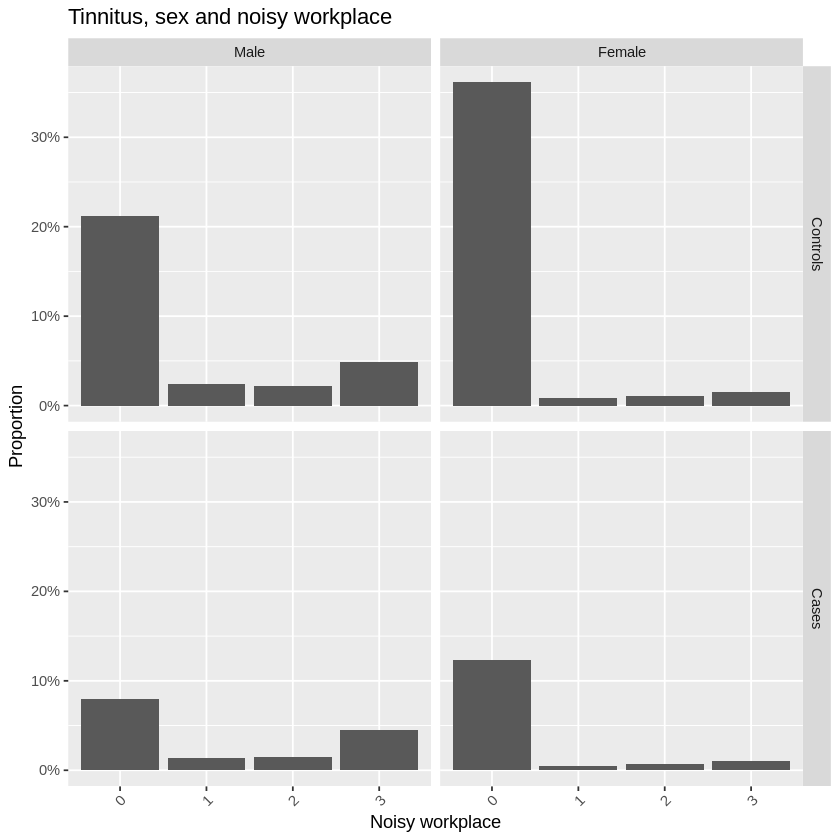

In [97]:
label_sex <- c("1" = "Female", "0" = "Male")
label_tin <- c("1" = "Cases", "0" = "Controls")
sex.tin.noise <- ggplot(tinnitus_complete, aes(x = noise_wp)) +
  geom_bar(aes(y = (..count..)/sum(..count..))) +
  labs(title = "Tinnitus, sex and noisy workplace",
       x = "Noisy workplace", 
       y = "Proportion of individuals") +
  scale_y_continuous(labels = scales::percent, name = "Proportion") +
  facet_grid(tinnitus ~ sex, labeller=labeller(sex = label_sex, tinnitus = label_tin)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
sex.tin.noise

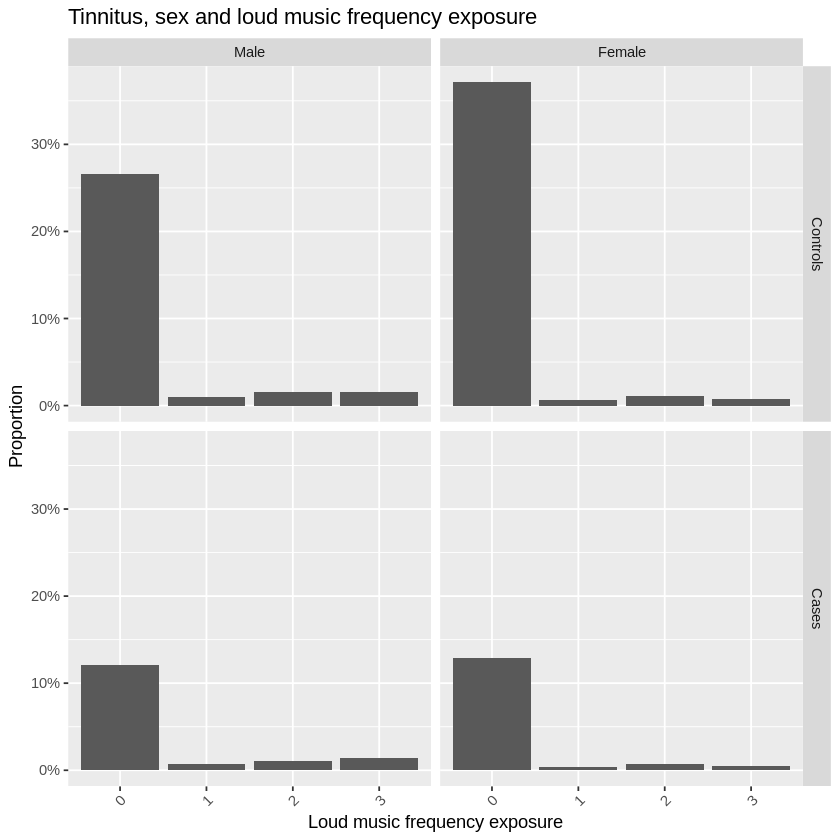

In [98]:
sex.tin.music <- ggplot(tinnitus_complete, aes(x = loud_music)) +
  geom_bar(aes(y = (..count..)/sum(..count..))) +
    labs(title = "Tinnitus, sex and loud music frequency exposure",
       x = "Loud music frequency exposure", 
       y = "Proportion of individuals") +
  scale_y_continuous(labels = scales::percent, name = "Proportion") +
  facet_grid(tinnitus ~ sex, labeller=labeller(sex = label_sex, tinnitus = label_tin)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
sex.tin.music

In [99]:
summary_noise_age <- ddply(tinnitus_complete, c("noise_wp"), summarise,
               N    = length(age),
               mean = mean(age),
               sd   = sd(age))
summary_noise_age

noise_wp,N,mean,sd
<fct>,<int>,<dbl>,<dbl>
0,106947,59.21024,8.476914
1,6969,57.96456,8.493229
2,7511,58.61377,8.577496
3,16418,60.26830,8.091813


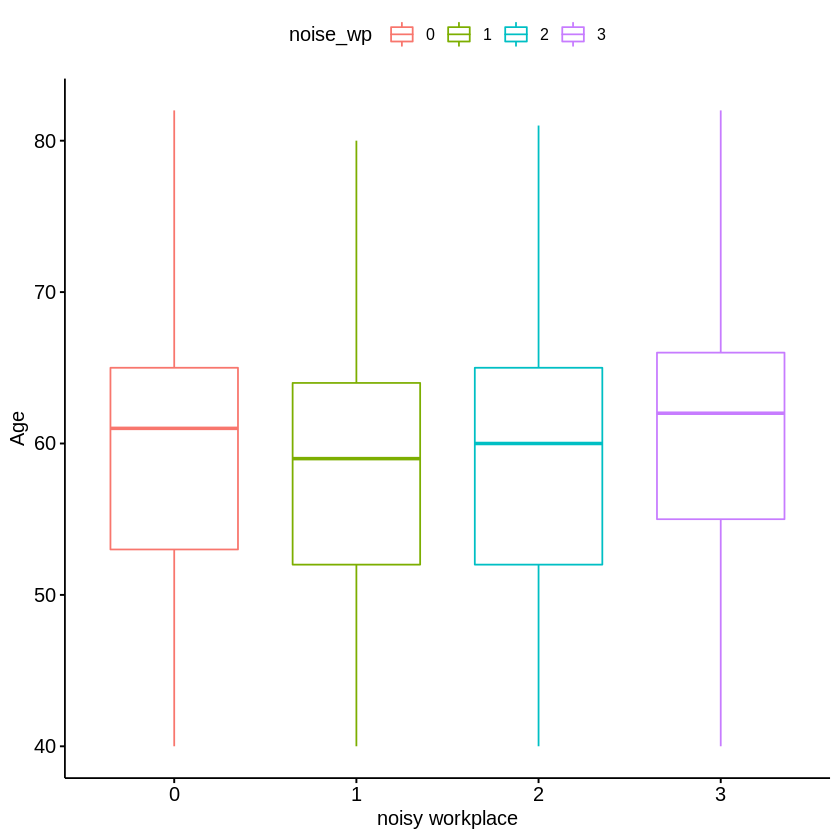

In [100]:
noise.boxp <- ggboxplot(tinnitus_complete, x = "noise_wp", y = "age", 
          color = "noise_wp",
          order = c("0", "1", "2", "3"),
          ylab = "Age", xlab = "noisy workplace")
noise.boxp

In [101]:
res1.aov <- aov(age ~ noise_wp, data = tinnitus_complete)
summary(res1.aov)
TukeyHSD(res1.aov)

                Df  Sum Sq Mean Sq F value Pr(>F)    
noise_wp         3   31738   10579   148.6 <2e-16 ***
Residuals   137841 9815050      71                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = age ~ noise_wp, data = tinnitus_complete)

$noise_wp
          diff        lwr        upr    p adj
1-0 -1.2456870 -1.5136960 -0.9776780 0.00e+00
2-0 -0.5964779 -0.8552493 -0.3377064 0.00e+00
3-0  1.0580588  0.8763491  1.2397684 0.00e+00
2-1  0.6492092  0.2886499  1.0097684 2.22e-05
3-1  2.3037458  1.9938123  2.6136792 0.00e+00
3-2  1.6545366  1.3525555  1.9565177 0.00e+00


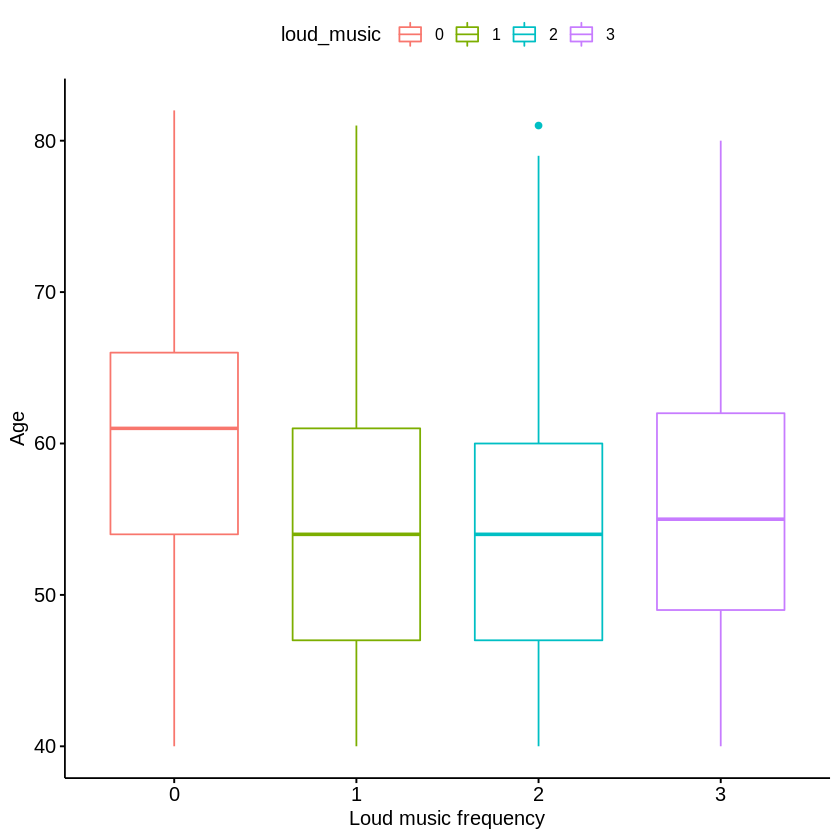

In [102]:
music.boxp <- ggboxplot(tinnitus_complete, x = "loud_music", y = "age", 
          color = "loud_music",
          order = c("0", "1", "2", "3"),
          ylab = "Age", xlab = "Loud music frequency")
music.boxp

In [103]:
res2.aov <- aov(age ~ loud_music, data = tinnitus_complete)
summary(res2.aov)
TukeyHSD(res2.aov)

                Df  Sum Sq Mean Sq F value Pr(>F)    
loud_music       3  379127  126376    1840 <2e-16 ***
Residuals   137841 9467660      69                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = age ~ loud_music, data = tinnitus_complete)

$loud_music
          diff        lwr         upr     p adj
1-0 -5.3610351 -5.7105052 -5.01156499 0.0000000
2-0 -5.8124579 -6.0933446 -5.53157132 0.0000000
3-0 -4.4437925 -4.7317466 -4.15583837 0.0000000
2-1 -0.4514228 -0.8914357 -0.01140998 0.0417906
3-1  0.9172426  0.4726849  1.36180037 0.0000007
3-2  1.3686655  0.9757284  1.76160250 0.0000000


Correlation between the two noise variables for cases and controls separately using Kendall correlation

In [104]:
cases <- tinnitus_complete %>%
  filter(tinnitus=="1")
noise_wp <- as.numeric(factor(cases$noise_wp,levels=c("0", "1", "2", "3"))) 
loud_music <- as.numeric(factor(cases$loud_music, levels=c("0", "1", "2", "3"))) 
m <- cbind(noise_wp, loud_music)
cor(m, method="kendall", use="pairwise")
cor.test(noise_wp, loud_music, method="kendall")

,noise_wp,loud_music
noise_wp,1.0000000,0.1353252
loud_music,0.1353252,1.0000000



	Kendall's rank correlation tau

data:  noise_wp and loud_music
z = 29.472, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.1353252 


In [105]:
controls <- tinnitus_complete %>%
  filter(tinnitus=="0")
noise_wp.ctr <- as.numeric(factor(controls$noise_wp,levels=c("0", "1", "2", "3"))) 
loud_music.ctr <- as.numeric(factor(controls$loud_music, levels=c("0", "1", "2", "3"))) 
m1 <- cbind(noise_wp.ctr, loud_music.ctr)
cor(m1, method="kendall", use="pairwise")
cor.test(noise_wp.ctr, loud_music.ctr, method="kendall")

,noise_wp.ctr,loud_music.ctr
noise_wp.ctr,1.0000000,0.1456364
loud_music.ctr,0.1456364,1.0000000



	Kendall's rank correlation tau

data:  noise_wp.ctr and loud_music.ctr
z = 47.272, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.1456364 


Heat map for variable correlation

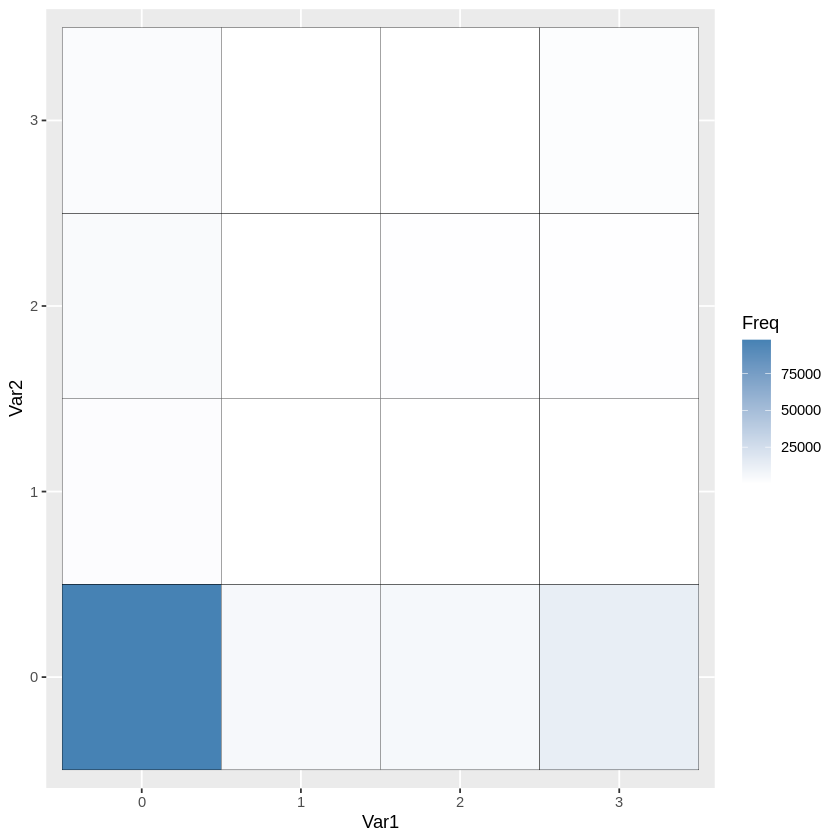

In [106]:
#Heat map
noisevar.df <- as.data.frame(table(tinnitus_complete$noise_wp, tinnitus_complete$loud_music))
ggplot(noisevar.df, aes(Var1, Var2)) +
  geom_tile(aes(fill = Freq), colour = "black") +
  scale_fill_gradient(low = "white", high = "steelblue")

Fluctuation plot

Warning message:
“Ignoring unknown aesthetics: stat, position”


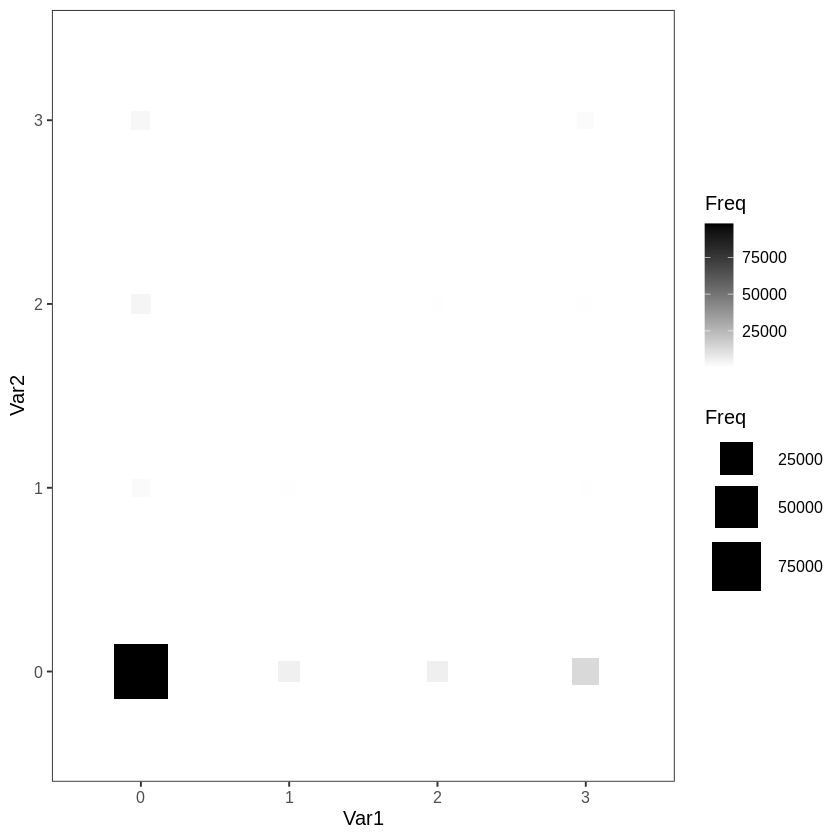

In [107]:
# Fluctuation plot
theme_nogrid <- function (base_size = 12, base_family = "") {
  theme_bw(base_size = base_size, base_family = base_family) %+replace% 
    theme(panel.grid = element_blank())   
}
ggplot(noisevar.df, aes(Var1, Var2)) +
  geom_point(aes(size = Freq, color = Freq, stat = "identity", position = "identity"), shape = 15) +
  scale_size_continuous(range = c(3,15)) + 
  scale_color_gradient(low = "white", high = "black") +
  theme_nogrid()

## 2. SRT phenotype (quantitative)

The phenotypes to be used are as follow:
1. Left ear f.20019
2. Right ear f.20021
3. Best ear (create a new variable extracting the min SRT value among f.20019 and f.20021)
4. Worst ear (create a new variable extracting the max SRT value among f.20019 and f.20021)

Age is calculated as follow:

- For people with repeated measures take age at last visit and measurement at last visit
- For people with only one measure take age at that visit

Sex corresponds to f.22001 (genetic sex):

- Male = 0
- Female = 1

Noise variable and loud music exposure frequency: same as for Tinnitus
                
1. Remove inconsistent individuals 
    - said 1,2 or 3 and in following visits said 0
    - said a higher exposure (e.g 3) and then a lower one (e.g 1 or 2) in following visits
2. Retain consistent individuals and use highest reported exposure

### a. Filter SRT codes
Obtain scores for right and left ear

Obtain the age at the last visit

In [ ]:
df.final.imp = read.csv('/SAY/dbgapstg/scratch/UKBiobank/phenotype_files/hearing_impairment/200814_UKBB_HI_genotypeqc_excr_impvars', header=TRUE)

In [ ]:
setwd('/home/dc2325/project/HI_UKBB')
library(tidyverse)

In [ ]:
srt_all = df.final.imp %>% 
  select(IID,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0, f.20019.0.0, f.20019.1.0, f.20019.2.0, f.20019.3.0,f.20021.0.0,f.20021.1.0,f.20021.2.0,f.20021.3.0)

srt_clean <-  srt_all %>% 
  mutate(srt_score_left = apply(select(., starts_with("f.20019")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]}),
         srt_score_right = apply(select(., starts_with("f.20021")), 1, function(x) {tail(x[!is.na(x)],n=1)[1]}),
         srt_age =  apply(select(., starts_with("f.21003")), 1, function(x)  {tail(x[!is.na(x)],n=1)[1]})
  )

head(srt_clean)

### e. Descriptive statistics

In [ ]:
#1555 who do not have srt score for left ear
left_ear_na <- srt_clean %>% 
  filter(is.na(srt_score_left) & !is.na(srt_score_right))
dim(left_ear_na)
#1554 who do not have srt score for right ear
right_ear_na <- srt_clean %>% 
  filter(is.na(srt_score_right) & !is.na(srt_score_left))
dim(right_ear_na)
#211763 have neither left ear nor right ear score
both_ear <- srt_clean %>% 
   filter(is.na(srt_score_left) & is.na(srt_score_right))
dim(both_ear)

In [ ]:
#create a categorical variable to classify the score for left and right ear
#137821 individuals have either right or left score, or both (216526 individuals who have neither the right nor left score are deleted)
#134058 have either right or left score, or both  (deleting the outliers)
srt_cat <- srt_clean %>%
  filter(!is.na(srt_score_left) | !is.na(srt_score_right)) %>% 
  mutate(srt_left_cat = case_when(
        srt_score_left < -5.5   ~  "normal",
        -5.5 <= srt_score_left & srt_score_left <= -3.5   ~  "insufficient",
          srt_score_left > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  mutate(srt_right_cat = case_when(
        srt_score_right < -5.5   ~  "normal",
        -5.5 <= srt_score_right & srt_score_right <= -3.5   ~  "insufficient",
          srt_score_right > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  #remove the score 8 (outlier) for both ears
  filter(!(srt_score_left == 8) & !(srt_score_right == 8))

#to use the function max/min, replace all NA to 0 for numerical variables 
srt_fill_na <- srt_cat
srt_fill_na[is.na(clean <- srt_cat)] <- 0
 

# Create two new variables to show the best ear and the worst ear
srt_best_worst <-  srt_fill_na %>% 
  mutate(best = apply(select(., starts_with("f.200")), 1, function(x) min(x[x!=0])),
         worst = apply(select(., starts_with("f.200")), 1, function(x) max(x[x!=0]))
  ) %>% 
  #replace the Inf and -Inf values with 0
  mutate(best = if_else(best == Inf, 0, best),
         worst = if_else(worst == -Inf, 0, worst)
  )


#replace 0 with NA
library(dplyr) 
srt_best_worst <- na_if(srt_best_worst, 0)


#summary statistics 
summary(srt_best_worst$srt_score_left)

In [ ]:
summary(srt_best_worst$srt_score_right)

In [ ]:
summary_left <- srt_best_worst %>%
  filter(!is.na(srt_score_left)) %>% 
  summarise(std_left =sd(srt_score_left),
          mean_left = mean(srt_score_left),
          median_left = median(srt_score_left),
          n = n()
          ) 

summary_left 

In [ ]:
summary_right <- srt_best_worst %>%
  filter(!is.na(srt_score_right)) %>% 
  summarise(std_right =sd(srt_score_right),
          mean_right = mean(srt_score_right),
          median_right = median(srt_score_right),
          n = n()
          ) 

summary_right

### Plots

In [ ]:
#histogram for SRT Score for Left Ear
left_plot = srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(x = srt_score_left,color = srt_left_cat)) +
      geom_histogram(binwidth = 0.1) +
   labs(
    title = "SRT Score for Left Ear (by category)",
    x = "SRT Score for Left ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-10, -5.5, -3.5, 0, 3.5, 5.5),
    labels = c("-10", "-5.5", "-3.5", "0", "3.5", "5.5")) +
  scale_color_discrete("SRT Score Category",labels=c("normal","insuficient","poor")) 


left_plot

In [ ]:
#QQ plot for SRT Score for Left Ear
qq_left_total <- srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(sample = (srt_score_left - mean(srt_score_left))/sd(srt_score_left))) +
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Left)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_left_total

In [ ]:
qq_left_by_cat <- srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(sample = (srt_score_left - mean(srt_score_left))/sd(srt_score_left), color = srt_left_cat)) +
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Left)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_left_by_cat

In [ ]:
#histogram for SRT Score for Right Ear 
right_plot <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(x = srt_score_right, color=srt_right_cat) ) +
      geom_histogram(binwidth = 0.1) +
  labs(
    title = "SRT Score for Right Ear (by category)",
    x = "SRT Score for Right ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-10, -5.5, -3.5, 0, 3.5, 5.5),
    labels = c("-10", "-5.5", "-3.5", "0", "3.5", "5.5")) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
  scale_color_discrete("SRT Score Category",labels=c("normal","insuficient","poor")) 
 
right_plot

In [ ]:
#QQ plot for SRT Score for Right Ear
qq_right_total <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(sample = (srt_score_right - mean(srt_score_right))/sd(srt_score_right))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Right)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_right_total

In [ ]:
qq_right_by_cat <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(sample = (srt_score_right - mean(srt_score_right))/sd(srt_score_right), color = srt_right_cat)) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Right)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_right_by_cat

In [ ]:
srt_best_worst_cat <- srt_best_worst %>%
  mutate(srt_best_cat = case_when(
        best < -5.5   ~  "normal",
        -5.5 <= best & best <= -3.5   ~  "insufficient",
          best > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  mutate(srt_worst_cat = case_when(
        worst < -5.5   ~  "normal",
        -5.5 <= worst & worst <= -3.5   ~  "insufficient",
          worst > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  filter(!is.na(best) | !is.na(worst))



best_plot <- srt_best_worst_cat %>% 
  ggplot(aes(x = best, color=srt_best_cat) ) +
      geom_histogram(binwidth = 0.1) +
  labs(
    title = "SRT Score for the Best Ear (by category)",
    x = "SRT Score for the Best ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-10, -5.5, -3.5, 0, 3.5, 5.5),
    labels = c("-10", "-5.5", "-3.5", "0", "3.5", "5.5")) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
  scale_color_discrete("SRT Score Category",labels=c("normal","insuficient","poor")) 
 
best_plot

In [ ]:
qq_best <- srt_best_worst_cat %>% 
  ggplot(aes(sample = (best - mean(best))/sd(best))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line(col= 'blue') +
  labs(title="QQ plot for the Best SRT Score",
       y = "SRT Score Quantiles",
       x = "normal Quantiles") + 
theme_classic()  

qq_best

In [ ]:
worst_plot <- srt_best_worst_cat %>% 
  ggplot(aes(x = worst, color=srt_worst_cat)) +
      geom_histogram(binwidth = 0.1) +
  labs(
    title = "SRT Score for the Worst Ear (by category)",
    x = "SRT Score for the Best ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-10, -5.5, -3.5, 0, 3.5, 5.5),
    labels = c("-10", "-5.5", "-3.5", "0", "3.5", "5.5")) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
  scale_color_discrete("SRT Score Category",labels=c("normal","insuficient","poor")) 
 

worst_plot

In [ ]:
qq_worst <- srt_best_worst_cat %>% 
  ggplot(aes(sample = (worst - mean(worst))/sd(worst))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line(col= 'blue') +
  labs(title="QQ plot for the Worst SRT Score",
       y = "SRT Score Quantiles",
       x = "normal quantiles") +
theme_classic()  

qq_worst